In [34]:
"""
1. python -m notebook
2. 
"""

'\n1. python -m notebook\n2. \n'

In [35]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

In [36]:
IMAGE_SIZE = 256      #all images are of size 256*256
BATCH_SIZE = 32      # standard batch size
CHANNELS = 3
EPOCHS = 25

In [37]:
# Loading data into tf dataset
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "PlantVillage",
    shuffle = True,
    image_size = (IMAGE_SIZE,IMAGE_SIZE),
    batch_size = BATCH_SIZE
)

Found 4627 files belonging to 5 classes.


Visulaisation of dataset..

In [38]:
class_names = dataset.class_names
class_names

['Pepper__bell___Bacterial_spot',
 'Pepper__bell___healthy',
 'Potato___Early_blight',
 'Potato___Late_blight',
 'Potato___healthy']

In [39]:
len(dataset)

145

In [40]:
for image_batch,lable_batch in dataset.take(1):
    print(image_batch.shape)
    print(lable_batch.numpy())

(32, 256, 256, 3)
[2 0 0 3 1 2 3 0 0 3 1 3 0 4 2 3 0 3 0 4 3 2 1 0 0 3 1 2 1 0 0 2]


In [41]:
for image_batch,lable_batch in dataset.take(1):
    print(image_batch[0].shape)
    print(lable_batch[0].numpy())

(256, 256, 3)
0


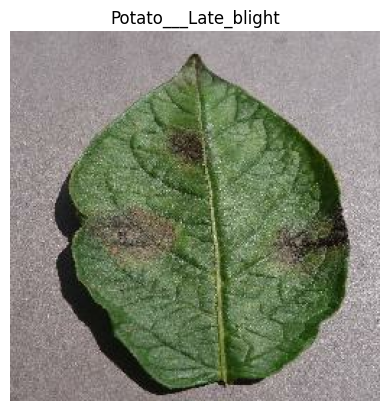

In [42]:
for image_batch,lable_batch in dataset.take(1):
    plt.axis("off")
    plt.title(class_names[lable_batch[0]])
    plt.imshow(image_batch[0].numpy().astype("uint8"))

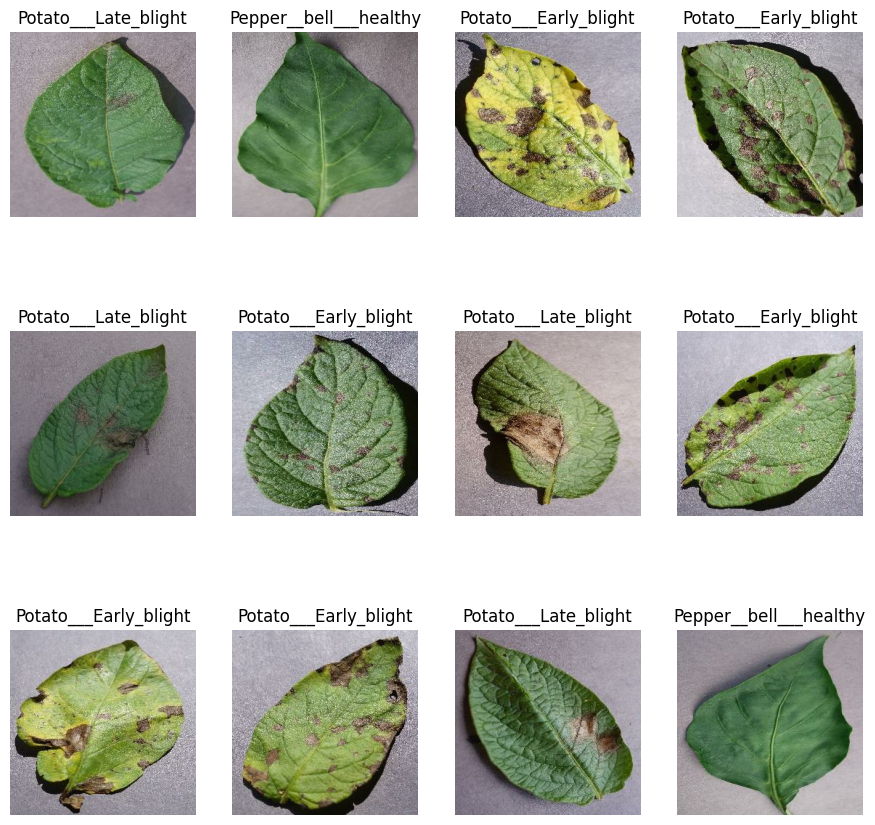

In [43]:
plt.figure(figsize=(11,11))
for image_batch,lable_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3,4,i+1)
        plt.axis("off")
        plt.title(class_names[lable_batch[i]])
        plt.imshow(image_batch[i].numpy().astype("uint8"))

In [44]:
train_size = 0.8
len(dataset)*train_size

116.0

In [45]:
145*32

4640

In [46]:
train_ds = dataset.take(116)
len(train_ds)

116

In [47]:
test_ds = dataset.skip(116)
len(test_ds)

29

In [48]:
val_size = 0.1
len(dataset)*val_size

14.5

In [49]:
val_ds = test_ds.take(14)
len(val_ds)

14

In [50]:
test_ds = test_ds.skip(14)
len(test_ds)

15

In [51]:
def get_dataset_partitions_tf(ds,train_split = 0.8, val_split=0.1, test_split=0.1, shuffle = True, shuffle_size = 10000):
    assert(train_split+test_split+val_split)==1
    
    ds_size = len(ds)
    
    if shuffle:
        ds=ds.shuffle(shuffle_size,seed=11)
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds,val_ds,test_ds

In [52]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [53]:
len(train_ds)

116

In [54]:
len(val_ds)

14

In [55]:
len(test_ds)

15

In [56]:
# with pre processing.. out dataset is optimised and training will run fast
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [57]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1.0/255)  
])

In [58]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2)  
])

Model Architecture
We use a CNN coupled with a Softmax activation in the output layer. We also add the initial layers for resizing, normalization and Data Augmentation.

We are going to use convolutional neural network (CNN) here. CNN is popular for image classification tasks. Watch below video to understand fundamentals of CNN

In [59]:
#Building CNN Model 
input_shape = (BATCH_SIZE, IMAGE_SIZE,IMAGE_SIZE,CHANNELS)
n_classes = 15
model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),  # 64 is hit and trail.. for more accuracy
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(32, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
    
])
model.build(input_shape=input_shape)

In [60]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_3 (Sequential)    (32, 256, 256, 3)         0         
_________________________________________________________________
sequential_4 (Sequential)    (32, 256, 256, 3)         0         
_________________________________________________________________
conv2d_6 (Conv2D)            (32, 254, 254, 32)        896       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (32, 127, 127, 32)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (32, 125, 125, 64)        18496     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (32, 62, 62, 64)          0         
_________________________________________________________________
conv2d_8 (Conv2D)            (32, 60, 60, 64)         

In [61]:
# compile model
model.compile(
    optimizer='adam',
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = False),
    metrics = ['accuracy']
)

# Model fit
history = model.fit(
    train_ds,
    batch_size = BATCH_SIZE,
    validation_data = val_ds,
    verbose = 1,
    epochs = EPOCHS
)

In [65]:
scores = model.evaluate(test_ds)

15/15 [==============================] - 4s 237ms/step - loss: 0.0604 - accuracy: 0.9792


we get 97.92% accuracy for our test dataset. This is considered to be a pretty good accuracy.

In [66]:
scores

[0.0603804849088192, 0.9791666865348816]

Scores is just a list containing loss and accuracy value

# Plotting the Accuracy and Loss Curves

In [67]:
history

In [68]:
history.params

{'verbose': 1, 'epochs': 25, 'steps': 116}

In [69]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [70]:
history.history['loss'][:5] # show loss for first 5 epochs

[1.5442982912063599,
 0.9211143851280212,
 0.6337704658508301,
 0.33367979526519775,
 0.27470922470092773]

In [71]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

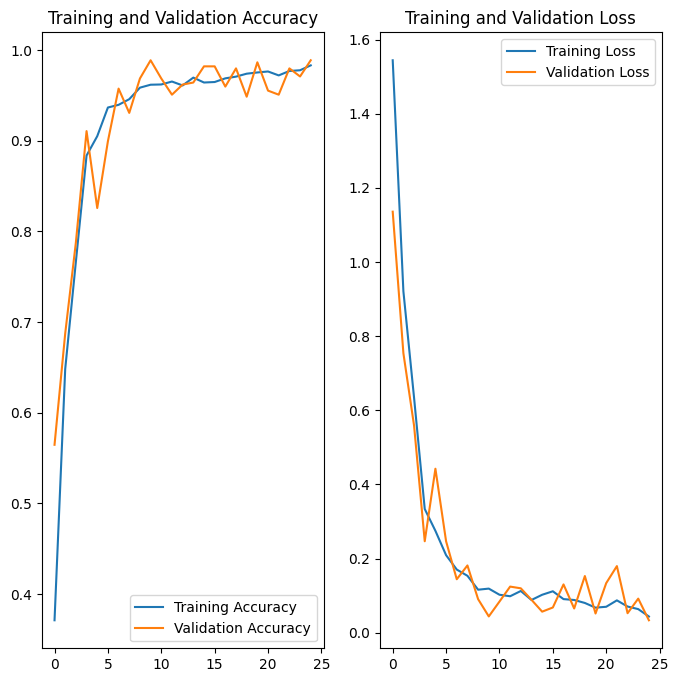

In [72]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# Run prediction on a sample image

Predict First Image
Actual label: Potato___Early_blight
Predicted label: Potato___Early_blight


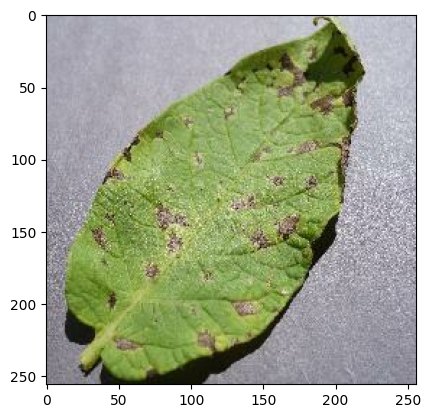

In [73]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("Predict First Image")
    plt.imshow(first_image)
    print("Actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("Predicted label:",class_names[np.argmax(batch_prediction[0])])

In [74]:
#Function for inference
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

Now run inference on few sample images

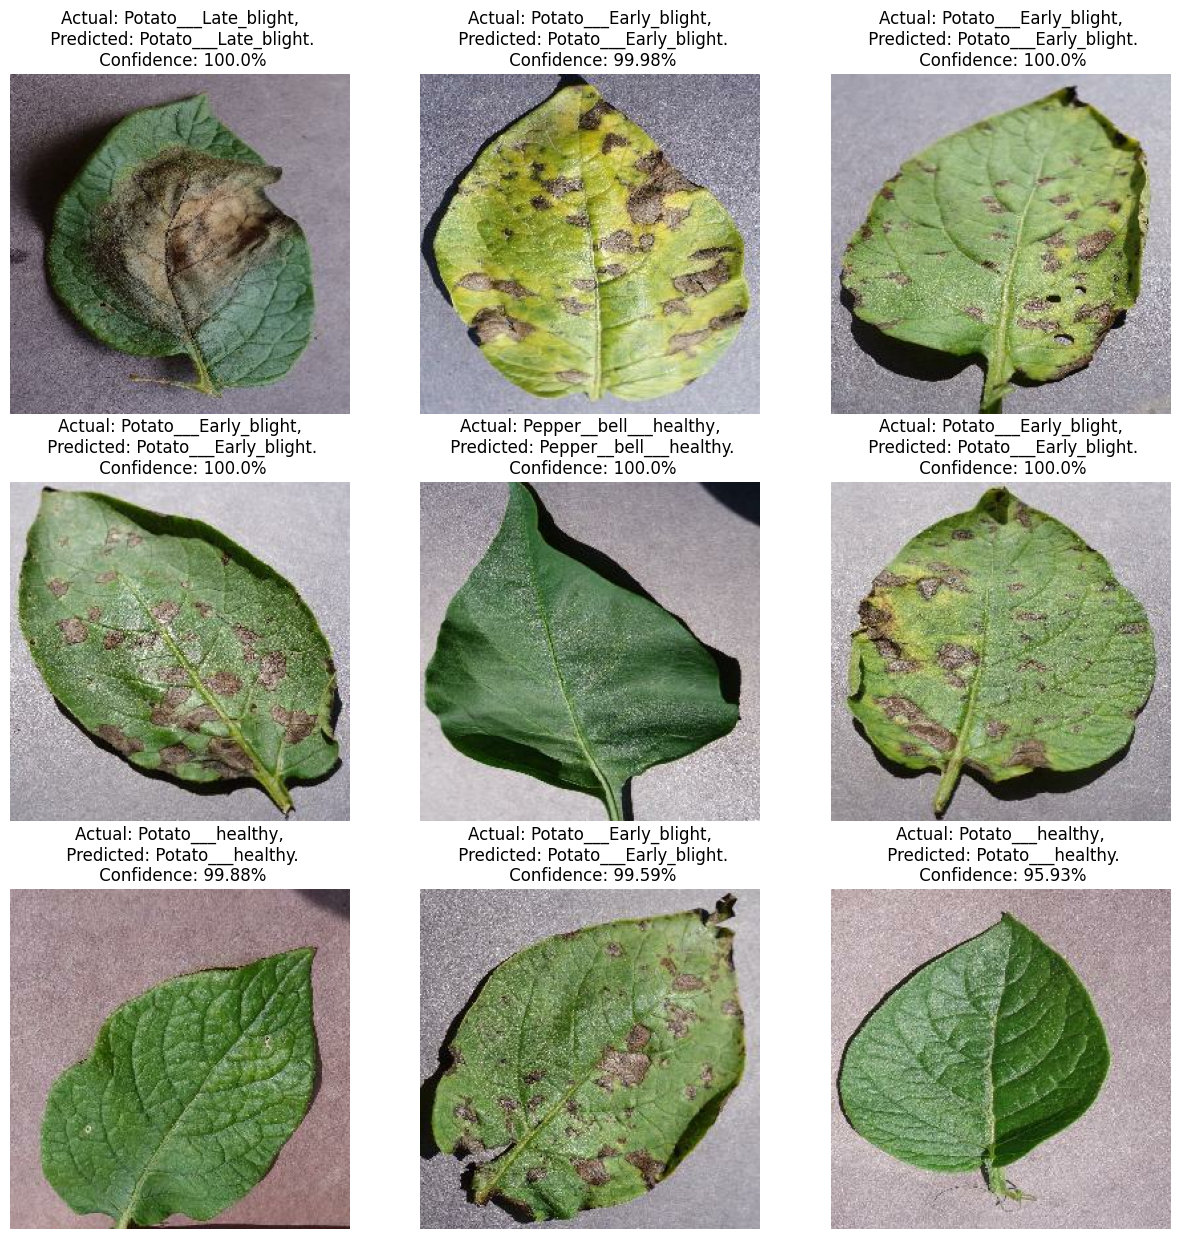

In [75]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

Saving the Model
We append the model to the list of models as a new version

In [80]:
import os
model_version=max([int(i) for i in os.listdir("../Models") + [0]])+1
model.save(f"../Models/{model_version}")

INFO:tensorflow:Assets written to: ../Models/1\assets


In [ ]:
model.save("DiseaseDetection_PotatoAndPepper.h5")